In [19]:
import sys
sys.path.insert(0, '../python_dms/lib/')
from dms import *
from tools_dms import *
from tools_trof import *
from PIL import Image
import scipy as scp

import scipy.io
import argparse
import os 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading image

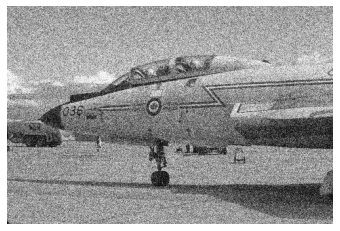

In [2]:
z = np.array(Image.open('10081_noisy.jpg').convert('L'))
plt.imshow(z,cmap='gray')
plt.axis('off')
plt.show()

## Parameters

In [3]:
# Blur or linear operators
A = np.ones_like(z)

norm_type = 'l1'# 'AT-fourier'
method = 'SLPAM' # 'PALM', 'PALM-eps-descent', 'SLPAM-eps-descent'


beta= 10    #smoothing param
lambd = 0.02 #lenght contour param

# maximum iteration
mit =300


In [8]:
test = DMS('', noise_type='Gaussian',blur_type='Gaussian',
                               beta=beta, lamb=lambd, method=method,MaximumIteration=mit,
                               noised_image_input=z, norm_type=norm_type,stop_criterion=1e-4, dkSLPAM=1e-4,
                               optD='OptD',A=A)


## Run

In [9]:
out = test.process()

## Display results

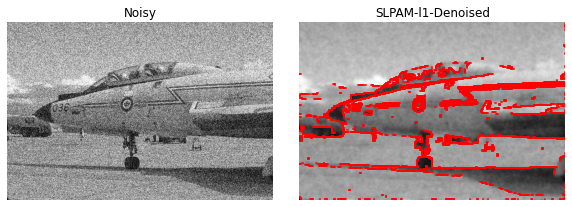

In [10]:
sf=plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.1, hspace=0)
ax1= plt.subplot(121)
ax1.imshow(z,cmap='gray')
plt.axis('off')
plt.title('Noisy')
ax2=plt.subplot(122)
ax2.imshow(out[1],cmap='gray')
draw_contour(out[0],'',fig=ax2)
plt.axis('off')
plt.title(method+'-'+norm_type+'-'+'Denoised')
plt.show()

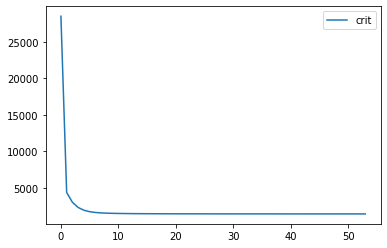

In [12]:
plt.figure()
plt.plot(out[3],label='crit')
plt.legend()
plt.show()

## Comparison between different methods

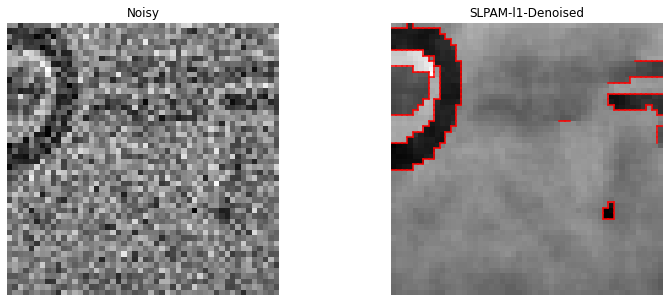

In [37]:
rows,cols = np.shape(z)
sf=plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.1, hspace=0)
ax1= plt.subplot(231)
ax1.imshow(z[rows//2-25:rows//2+25,cols//2-25:cols//2+25],cmap='gray')
plt.axis('off')
plt.title('Noisy')
ax2=plt.subplot(232)
ax2.imshow(out_slpaml1[1][rows//2-25:rows//2+25,cols//2-25:cols//2+25],cmap='gray')
draw_contour(out_slpaml1[0][rows//2-25:rows//2+25,cols//2-25:cols//2+25],'',fig=ax2)
plt.axis('off')
plt.title('SLPAM'+'-'+'l1'+'-'+'Denoised')
plt.show()

Epsilon:  0.5


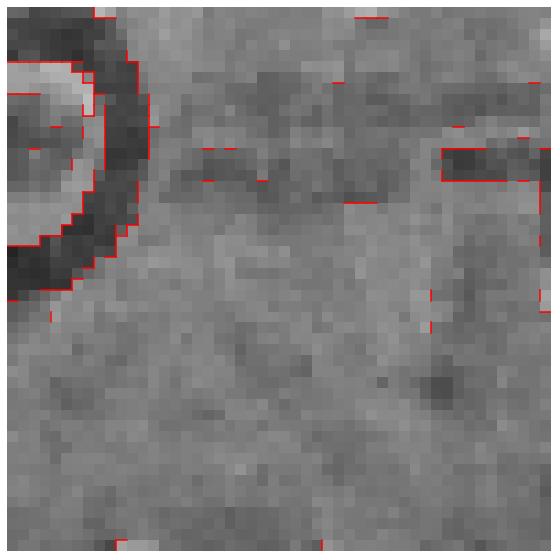

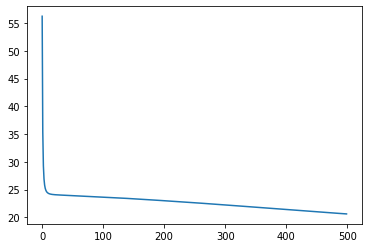

Epsilon:  0.3333333333333333


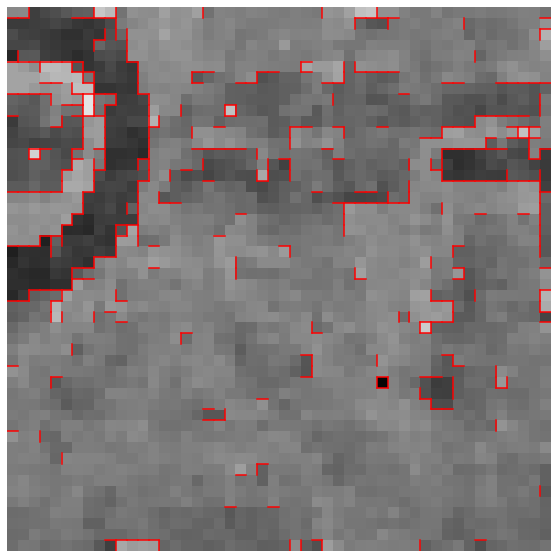

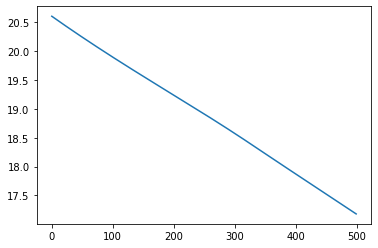

Epsilon:  0.2222222222222222


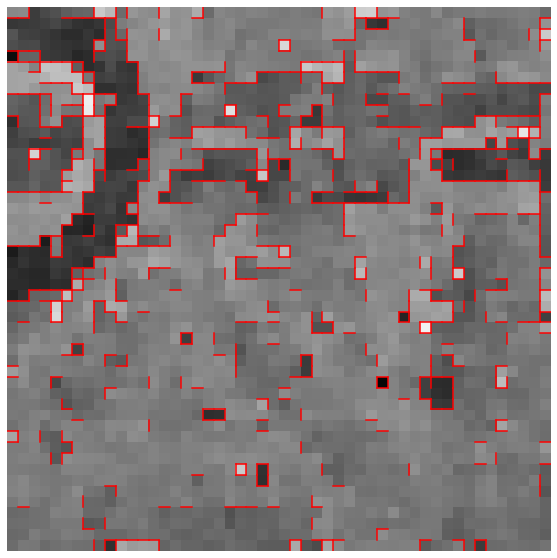

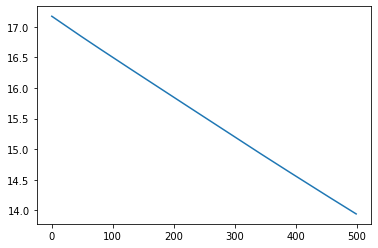

Epsilon:  0.14814814814814814


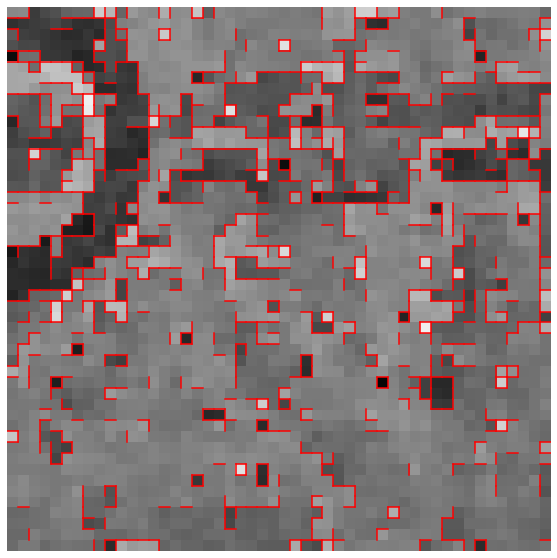

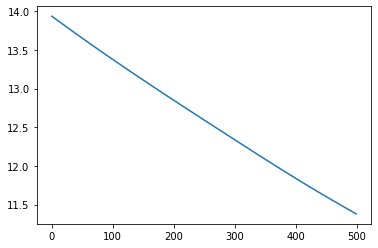

Epsilon:  0.09876543209876543


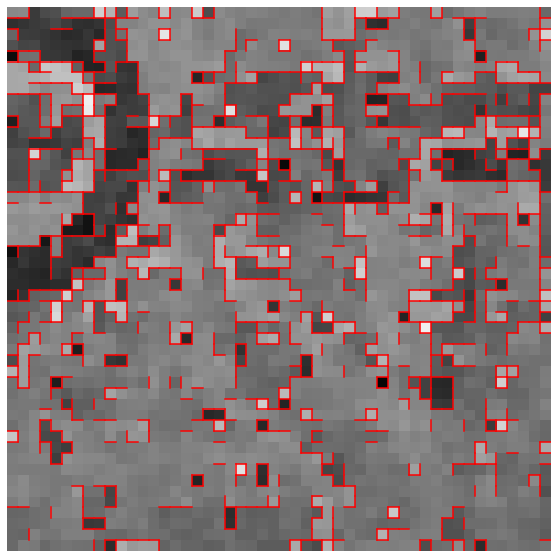

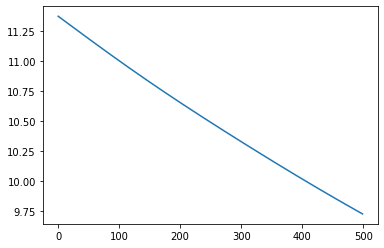

Epsilon:  0.06584362139917695


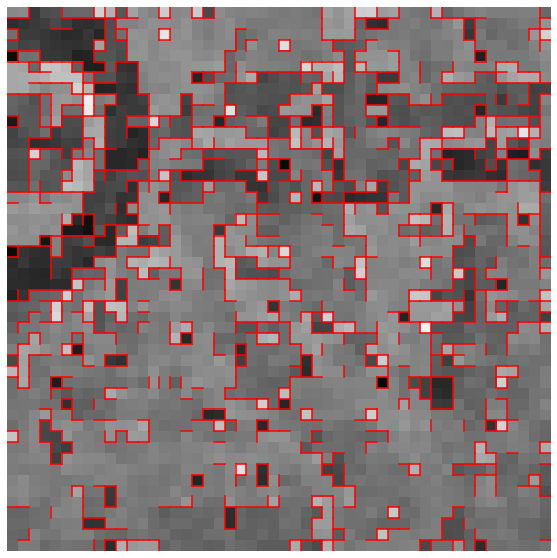

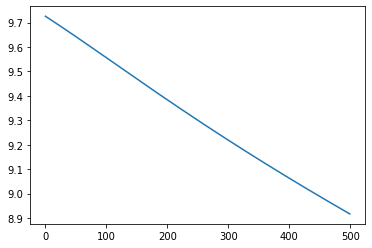

Epsilon:  0.0438957475994513


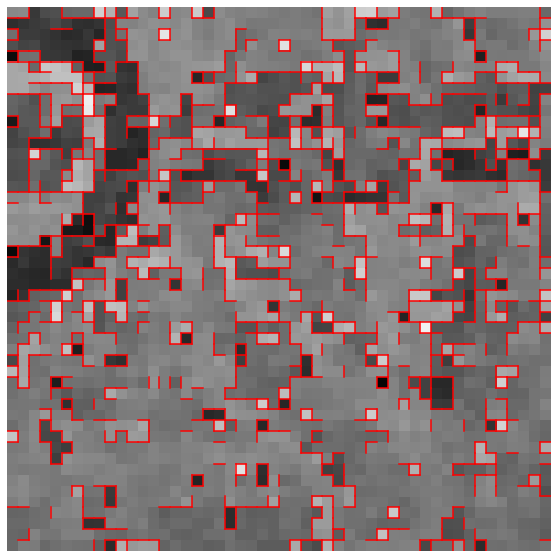

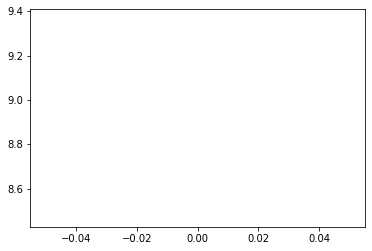

Epsilon:  0.029263831732967534


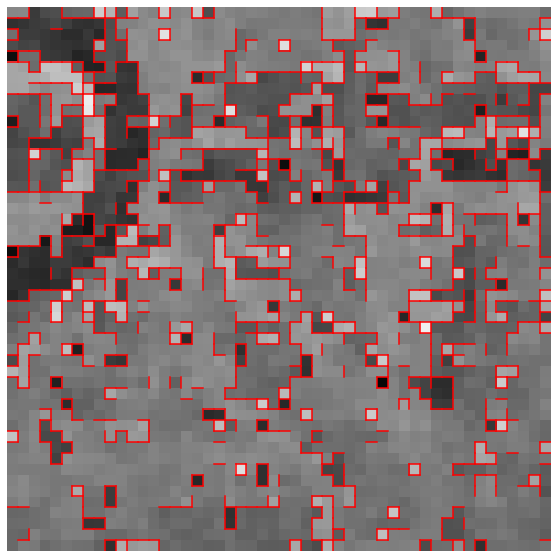

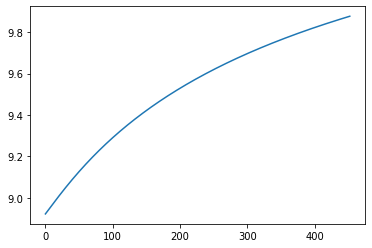

Epsilon:  0.01950922115531169


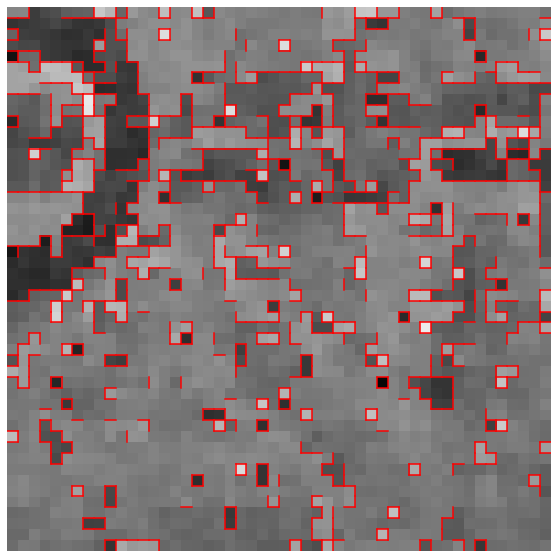

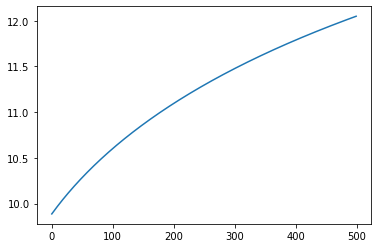

Epsilon:  0.013006147436874461


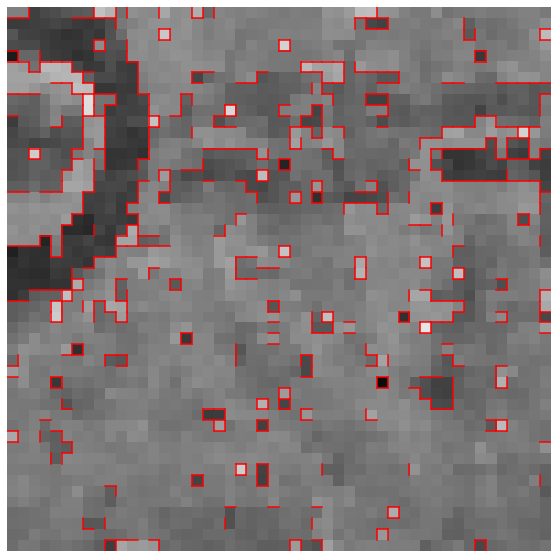

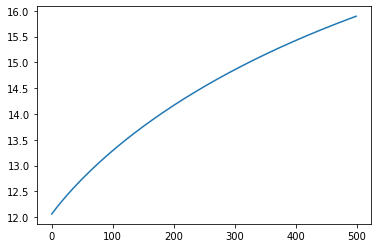

In [48]:
z_crop = z[rows//2-25:rows//2+25,cols//2-25:cols//2+25]
A_crop = np.ones_like(z_crop)
norm_type = 'AT-fourier'
method = 'PALM-eps-descent'
# Ambrosio-Tortorelli paramters
eps = 0.5
# minimum eps AT in the case of descreasingepsilon 
eps_AT_min= 0.01

palm_AT_descent = DMS('', noise_type='Gaussian',blur_type='Gaussian',
                               beta=4, lamb=0.001, method=method,MaximumIteration=500,
                               noised_image_input=z_crop, norm_type=norm_type,stop_criterion=1e-4,
                               optD='OptD',eps=eps,eps_AT_min=eps_AT_min,A=A_crop)
out_palmAT_descent = palm_AT_descent.process()

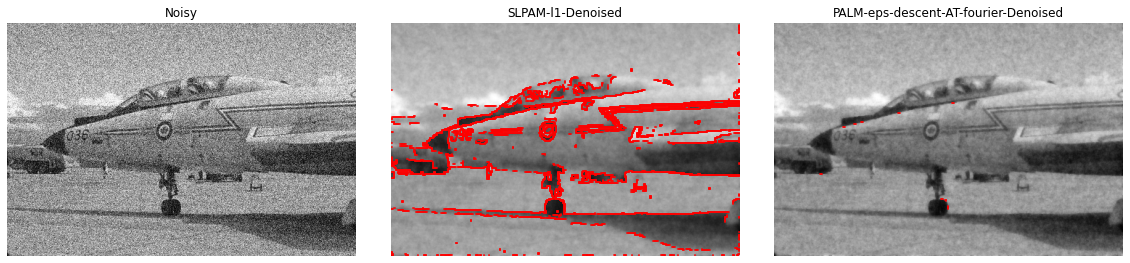

In [21]:


sf=plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.1, hspace=0)
ax1= plt.subplot(231)
ax1.imshow(z,cmap='gray')
plt.axis('off')
plt.title('Noisy')
ax2=plt.subplot(232)
ax2.imshow(out_slpaml1[1],cmap='gray')
draw_contour(out_slpaml1[0],'',fig=ax2)
plt.axis('off')
plt.title('SLPAM'+'-'+'l1'+'-'+'Denoised')
ax3=plt.subplot(233)
ax3.imshow(out_palmAT_descent[1],cmap='gray')
draw_contour(out_palmAT_descent[0],'',fig=ax2)
plt.axis('off')
plt.title('PALM-eps-descent'+'-'+ 'AT-fourier'+'-'+'Denoised')
plt.show()

ax4= plt.subplot(231)
ax4.imshow(z[],cmap='gray')
plt.axis('off')
plt.title('Noisy')
ax5=plt.subplot(232)
ax5.imshow(out_slpaml1[1],cmap='gray')
draw_contour(out_slpaml1[0],'',fig=ax2)
plt.axis('off')
plt.title('SLPAM'+'-'+'l1'+'-'+'Denoised')
ax6=plt.subplot(233)
ax6.imshow(out_palmAT_descent[1],cmap='gray')
draw_contour(out_palmAT_descent[0],'',fig=ax2)
plt.axis('off')
plt.title('PALM-eps-descent'+'-'+ 'AT-fourier'+'-'+'Denoised')
plt.show()
